In [1]:
import pandas as pd
import numpy as np

import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

import sys

import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display


from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier


from IPython.display import Audio

from utils.audio_preprocess import *
from utils.septr import SeparableTr
from utils.feature_exctraction import get2d_data
from utils. post_analysis import *

In [2]:
from tqdm import tqdm

In [3]:
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D,MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers.legacy import Adam 

#import warnings
#if not sys.warnoptions:
#    warnings.simplefilter("ignore")
#warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
# # ave maria 🙏🏻🙏🏿
# from scikeras.wrappers import KerasClassifier

In [5]:
data_path = data_path()

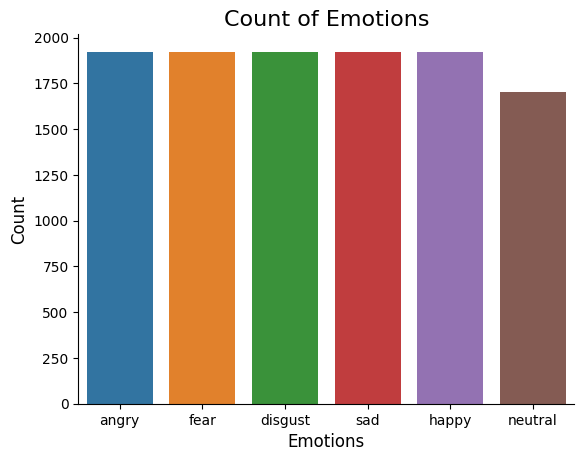

In [6]:
# Plot the count of Emotions
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [7]:
data_path.shape

(11318, 2)

### Data Augmentation

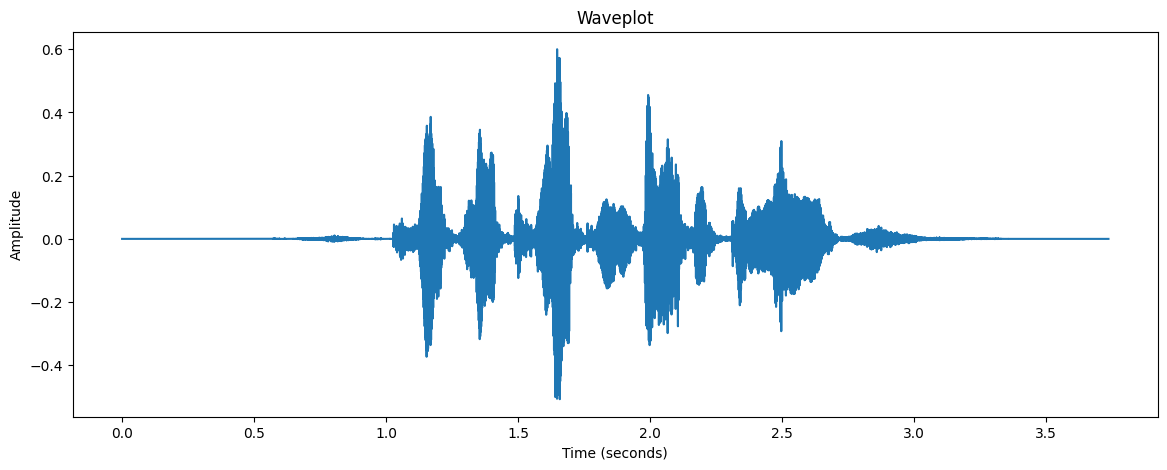

In [21]:
path = np.array(data_path.Path[data_path.Emotions=='fear'])[4]
data, sampling_rate = librosa.load(path)

duration = len(data) / sampling_rate
time = np.linspace(0, duration, len(data))

plt.figure(figsize=(14, 5))
plt.plot(time, data)
plt.title('Waveplot')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()
Audio(data, rate=sampling_rate)

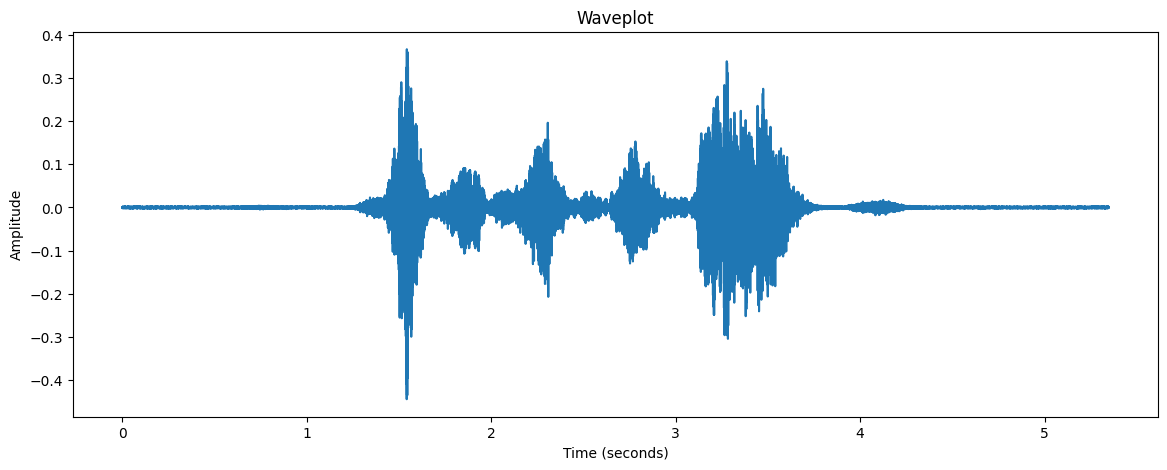

In [9]:
random_audio = random_augmentation(data, sampling_rate)

# Calculate time values
duration = len(random_audio) / sampling_rate
time = np.linspace(0, duration, len(random_audio))

# Create waveplot
plt.figure(figsize=(14, 5))
plt.plot(time, random_audio)
plt.title('Waveplot')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()
Audio(random_audio, rate=sampling_rate)

### Feature Extraction

In [10]:
x_train, y_train, x_test, y_test, encoder = get2d_data(data_path, feats = True, max_aug = 3, save_png=False)

Exctracting and processing data...
Train exctraction complete. x_train -> 21460
Test exctraction complete. x_test -> 2830
Final processing for NN.


In [13]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21460, 162), (21460, 6), (2830, 162), (2830, 6))

In [46]:
#np.save('Data/x_train.npy', x_train)
#np.save('Data/y_train.npy', y_train)
#np.save('Data/x_test.npy',  x_test)
#np.save('Data/y_test.npy',  y_test)

In [4]:
x_train = np.load('Data/x_train.npy')
y_train = np.load('Data/y_train.npy')
x_test = np.load('Data/x_test.npy')
y_test = np.load('Data/y_test.npy')


In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
for i in range(x_train.shape[0]):
    x_train[i] = scaler.fit_transform(x_train[i])


for i in range(x_test.shape[0]):
    x_test[i] = scaler.fit_transform(x_test[i])

# making our data compatible to model.
#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

### PCA

In [ ]:
pca = PCA()
pca.fit(x_train)

# Calcola la varianza spiegata cumulativa
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Plot dello Scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o')
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('Scree Plot - Valutazione della PCA')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA()
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)

### Base NN

In [11]:
def base_model():
    model=Sequential()
    model.add(Input(shape=x_train.shape[1:], batch_size = 32)) #input
    #model.add(Dense(units=256, activation='relu'))
    #model.add(Dropout(0.25))
    #model.add(BatchNormalization())
    #model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))    
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(units=86, activation='relu'))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())

    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Dense(units=16, activation='relu'))

    model.add(Dense(units=6, activation='softmax'))

    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [12]:
base_model().fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    callbacks=[EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=10)]
)

Epoch 1/100
391/391 [==============================] - 1s 2ms/step - loss: 1.7378 - accuracy: 0.2538 - val_loss: 1.6266 - val_accuracy: 0.3099
Epoch 2/100
391/391 [==============================] - 0s 1ms/step - loss: 1.5858 - accuracy: 0.3201 - val_loss: 1.5213 - val_accuracy: 0.3693
Epoch 3/100
391/391 [==============================] - 0s 1ms/step - loss: 1.5386 - accuracy: 0.3434 - val_loss: 1.5285 - val_accuracy: 0.3784
Epoch 4/100
391/391 [==============================] - 0s 1ms/step - loss: 1.5245 - accuracy: 0.3550 - val_loss: 1.4858 - val_accuracy: 0.4004
Epoch 5/100
391/391 [==============================] - 0s 1ms/step - loss: 1.5194 - accuracy: 0.3544 - val_loss: 1.5509 - val_accuracy: 0.4014
Epoch 6/100
391/391 [==============================] - 1s 1ms/step - loss: 1.5107 - accuracy: 0.3625 - val_loss: 1.5046 - val_accuracy: 0.4032
Epoch 7/100
391/391 [==============================] - 0s 1ms/step - loss: 1.4948 - accuracy: 0.3693 - val_loss: 1.6429 - val_accuracy: 0.3495

In [11]:
large_base_model = Sequential()
large_base_model.add(Input(shape=x_train.shape[1:], batch_size=64))  #input

large_base_model.add(Dense(units=184, activation="relu"))
large_base_model.add(Dropout(0.2))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=256, activation="relu"))
large_base_model.add(Dropout(0.2))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=512, activation="relu"))
large_base_model.add(Dropout(0.25))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=256, activation="relu"))
large_base_model.add(Dropout(0.2))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=128, activation="relu"))
large_base_model.add(Dropout(0.2))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=84, activation="relu"))
large_base_model.add(Dropout(0.15))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=64, activation="relu"))
large_base_model.add(Dropout(0.1))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=32, activation="relu"))
large_base_model.add(Dropout(0.1))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=16, activation="relu"))
large_base_model.add(Dropout(0.05))
large_base_model.add(BatchNormalization())

large_base_model.add(Dense(units=8, activation="relu"))

large_base_model.add(Dense(units=6, activation="softmax"))
large_base_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [12]:
history = large_base_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    callbacks=[EarlyStopping(monitor="val_accuracy", min_delta=0.005, patience=10)]
)

Epoch 1/100
671/671 [==============================] - 4s 4ms/step - loss: 2.0002 - accuracy: 0.1796 - val_loss: 2.3594 - val_accuracy: 0.1834
Epoch 2/100
671/671 [==============================] - 2s 3ms/step - loss: 1.8667 - accuracy: 0.1910 - val_loss: 2.2730 - val_accuracy: 0.2173
Epoch 3/100
671/671 [==============================] - 2s 3ms/step - loss: 1.8082 - accuracy: 0.2140 - val_loss: 1.9739 - val_accuracy: 0.2240
Epoch 4/100
671/671 [==============================] - 2s 4ms/step - loss: 1.7685 - accuracy: 0.2317 - val_loss: 2.2253 - val_accuracy: 0.2625
Epoch 5/100
671/671 [==============================] - 2s 4ms/step - loss: 1.7301 - accuracy: 0.2599 - val_loss: 1.9426 - val_accuracy: 0.2859
Epoch 6/100
671/671 [==============================] - 2s 4ms/step - loss: 1.6917 - accuracy: 0.2759 - val_loss: 1.9474 - val_accuracy: 0.2795
Epoch 7/100
671/671 [==============================] - 2s 4ms/step - loss: 1.6585 - accuracy: 0.2929 - val_loss: 1.9826 - val_accuracy: 0.2993

In [14]:
print("Accuracy of our model on test data : " , large_base_model.evaluate(x_test,y_test)[1]*100 , "%")

89/89 [==============================] - 0s 986us/step - loss: 1.3284 - accuracy: 0.5244
Accuracy of our model on test data :  52.43816375732422 %


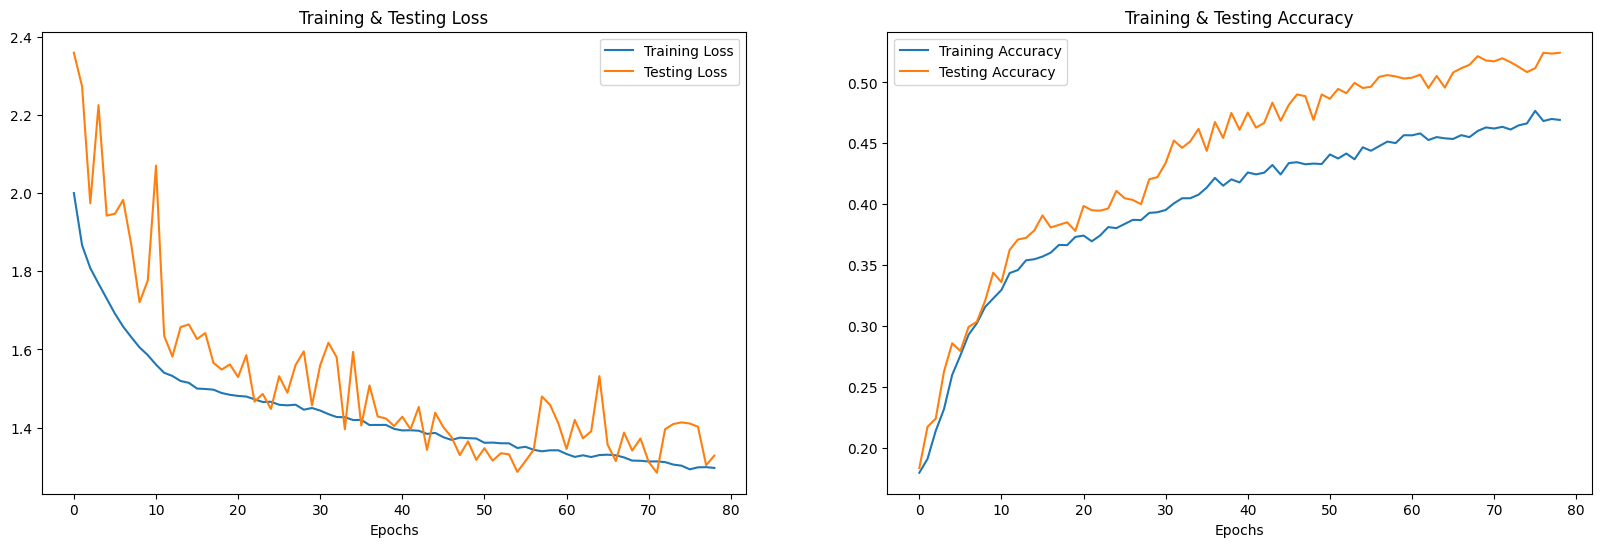

In [15]:
epoch_view(history, num_epochs = len(history.history['loss']))

89/89 [==============================] - 0s 992us/step


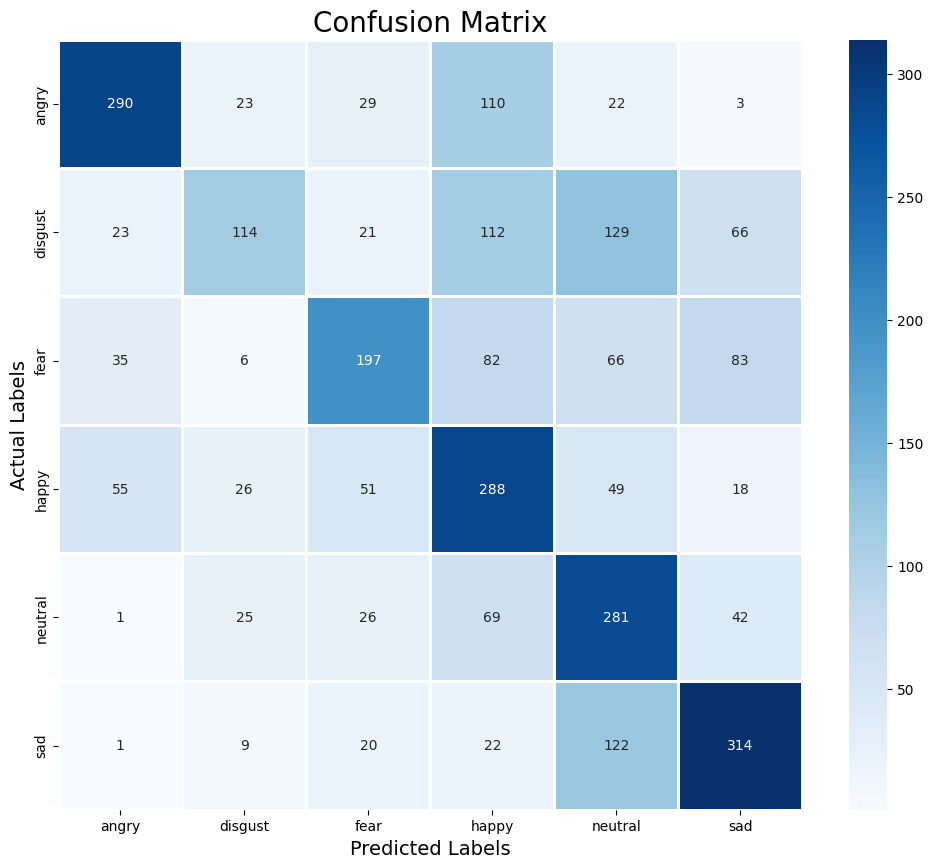

,Predicted Labels,Actual Labels
0,happy,happy
1,happy,fear
2,neutral,disgust
3,neutral,fear
4,disgust,disgust
5,neutral,neutral
6,happy,happy
7,fear,fear
8,sad,disgust
9,neutral,fear


In [16]:
y_pred, y_test = pred_result(large_base_model, x_test, y_test, encoder = encoder, cm_bool = True)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.61      0.66       477
     disgust       0.56      0.25      0.34       465
        fear       0.57      0.42      0.48       469
       happy       0.42      0.59      0.49       487
     neutral       0.42      0.63      0.50       444
         sad       0.60      0.64      0.62       488

    accuracy                           0.52      2830
   macro avg       0.55      0.52      0.52      2830
weighted avg       0.55      0.52      0.52      2830



### k-NN

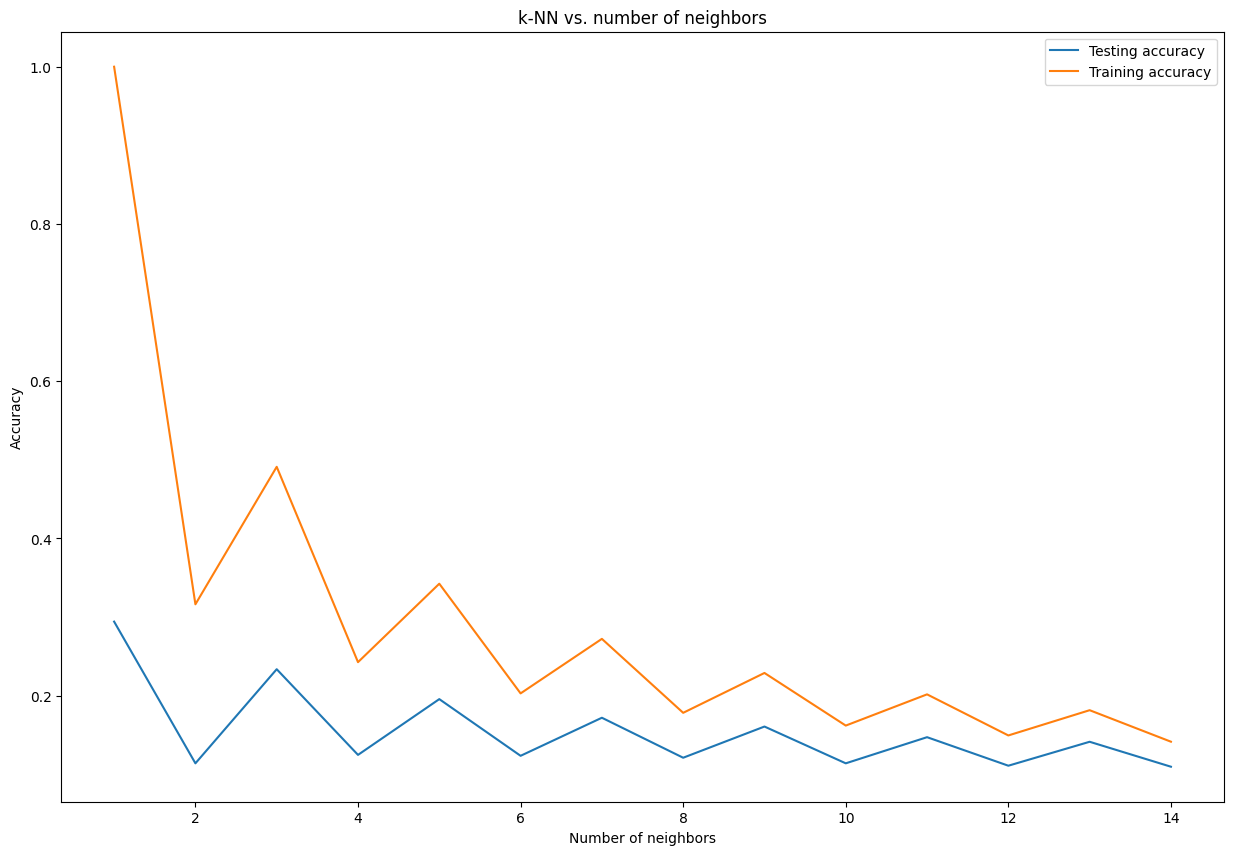

In [28]:
neighbors = range(1,15,1)
knn_train_score, knn_val_score = validation_curve(kNN(), x_train, y_train, param_name='n_neighbors', param_range=neighbors, cv=5)

plt.subplots(figsize=(15, 10))
plt.title('k-NN vs. number of neighbors')
plt.plot(neighbors, np.mean(knn_val_score, 1), label='Testing accuracy')
plt.plot(neighbors, np.mean(knn_train_score, 1), label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
k_grid = {'n_neighbors': range(1, 10, 1)}
knn_learner = GridSearchCV(estimator=kNN(), param_grid=k_grid, cv=5, return_train_score=True)
knn_learner.fit(x_train, y_train)
knn_learner.best_params_, knn_learner.best_score_

### Decision Tree

In [ ]:
depths = np.arange(1,50,1)
learner = DecisionTreeClassifier()
train_score, val_score = validation_curve(learner, x_train, y_train, param_name='max_depth', param_range=depths, cv=3)

plt.subplots(figsize=(15, 10))
plt.title('Tree classifier vs. depth')
plt.plot(depths, np.mean(val_score, 1), label='CV accuracy')
plt.plot(depths, np.mean(train_score, 1), label='Training accuracy')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
k_grid = {'max_depth': range(10, 30, 1)}
tree_learner = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=k_grid, cv=3, return_train_score=True)
tree_learner.fit(x_train, y_train)
tree_learner.best_params_, tree_learner.best_score_

In [ ]:
tree_model = tree_learner.best_estimator_
tree_cv_scores = cross_val_score(tree_model, x_train, y_train, cv=5)
print("Cross-Validation Score for best Tree model: ", tree_cv_scores.mean())

### CNN

In [36]:
def cnn_model(nfilters1=256, nfilters2=162, nfilters3=128, nfilters4=64, size_kernel=5, nstrides=1, size_pool=5):
    model=Sequential()
    model.add(Conv1D(filters=nfilters1, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters=nfilters2, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.1))

    model.add(Conv1D(filters=nfilters3, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.1))

    model.add(Conv1D(filters=nfilters4, kernel_size=size_kernel, strides=nstrides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    #model.add(Dropout(0.2))

    model.add(Dense(units=6, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    #model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    #rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.30, verbose=0, patience=2, min_lr=0.0000001)

    #model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])    
    
    #model.summary()

    return model


In [ ]:
cnn_model().fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, callbacks=[EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=10)])

### Hyperparameter Tuning

In [ ]:
model = KerasClassifier(
    model=cnn_model, 
    verbose=0, 
    batch_size=32, 
    loss="categorical_crossentropy", 
    nfilters1 = 64, 
    nfilters2 = 64, 
    nfilters3 = 64, 
    nfilters4 = 64, 
    size_kernel = 3,
    nstrides = 1,
    size_pool = 5
    )

In [ ]:
param_grid = {
    'nfilters1': [256, 128, 64, 32],
    'nfilters2': [256, 128, 64, 32],
    'nfilters3': [256, 128, 64, 32],
    'nfilters4': [256, 128, 64, 32],
    'size_kernel': [3, 5],
    'nstrides': [1, 3],
    'size_pool': [3, 5, 8]
    #'optimizer': ['adam']
}

# Grid
grid = RandomizedSearchCV(estimator=base_model, param_distributions=param_grid, cv=3, verbose=3, n_jobs=3, n_iter=1000) #GridSearchCV
grid_result = grid.fit(x_train, y_train)

# Print
print("Best hyperparameter: ", grid_result.best_params_)
print("Best accuracy: ", grid_result.best_score_)

best_model = grid_result.best_estimator_
val_accuracy = best_model.score(x_test, y_test)
print("Validaton accuracy: ", val_accuracy)

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.30, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])

### SepTr

In [ ]:
# Determine batch_size and sequence_length
batch_size = 100 #Crema_df.shape[0]
sequence_lengths = []

# Loop over audio files to compute sequence lengths
for file_path in Crema_df.Path.head(100):
    audio, _ = librosa.load(file_path)  # Load audio file
    sequence_lengths.append(len(audio))

# Determine the maximum sequence length
max_sequence_length = max(sequence_lengths)
# Create a list to hold the input spectrograms
input_dim = 128  # Dimension of input spectrogram
input_spectrograms = []

# Loop over audio files again to compute and store spectrograms
for file_path in Crema_df.Path.head(100):
    audio, _ = librosa.load(file_path)  # Load audio file
    spectrogram = librosa.feature.melspectrogram(y=audio)  # Compute spectrogram
    spectrogram = librosa.power_to_db(spectrogram)  # Convert to dB scale
    spectrogram = torch.tensor(spectrogram.T)  # Transpose and convert to tensor
    input_spectrograms.append(spectrogram)

# Determine the new batch size and adjust the tensor size
batch_size = len(input_spectrograms)
input_spectrograms_resized = torch.zeros(batch_size, max_sequence_length, input_dim)
for i, spectrogram in enumerate(input_spectrograms):
    length = min(max_sequence_length, spectrogram.size(0))
    input_spectrograms_resized[i, :length, :] = spectrogram[:length, :]



In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on the word array and transform the words into integers
y_train = label_encoder.fit_transform(y_train)

y_test = label_encoder.fit_transform(y_test)

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Estrazione delle features e dei target dal DataFrame
features = x_train
target = integer_array

# Trasformazione in tensori PyTorch
features_tensor = torch.tensor(features, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.int8)

# Creazione del dataset
dataset = TensorDataset(features_tensor, target_tensor)

# Creazione del dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch.optim as optim

num_classes = 6  # Numero di classi di output

model = AudioCNN(num_classes)

# Definizione della funzione di perdita e dell'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Addestramento del modello
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
input_dim = 128  # Dimension of input spectrogram
hidden_dim = 256  # Dimension of hidden layers
num_heads = 4  # Number of attention heads
num_layers = 6  # Number of SepTr encoder layers

model = SepTr(input_dim, hidden_dim, num_heads, num_layers)
output = model(input_spectrograms_resized)

### Melspectrogram

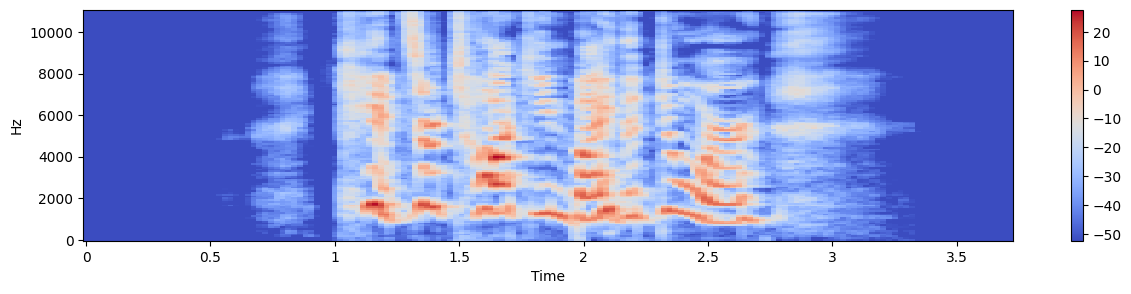

In [22]:
mel = librosa.feature.melspectrogram(y=data, sr=22050) 
mel_spec_db = librosa.power_to_db(mel)
plt.figure(figsize=(15, 3))
librosa.display.specshow(mel_spec_db, sr=22050, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
mel_spec_db

### Chromagram

In [ ]:
stft = np.abs(librosa.stft(data))
chroma_stft = librosa.feature.chroma_stft(S=stft, sr=22050)

In [ ]:
# Plot the chroma feature
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()

In [ ]:
chroma_stft.shape